In [1]:
import sys, os, glob, warnings, logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest, get_segments_mean
from scipy.stats import ttest_ind

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures

mkdir: ../jupyter_figures: File exists


In [2]:
# Read in the data
df = pd.read_csv('../data/SMG-pHH3-time-course/210206-SMG-time-course-proliferation-IF-40x-MIP-pHH3-7371.txt', sep='\t')
df.head()

# Annotate groups
groups = ['1']*7 + ['7']*14 + ['13']*14 + ['20']*14
df['groups'] = groups

# Calculate ratios
df['percent_pHH3_thres_area_surf'] = df.pHH3_thres_area_surf/df.area_surf*100
df['percent_pHH3_thres_area_in'] = df.pHH3_thres_area_in/df.area_in*100
df['ratio_pHH3_surf_to_in'] = df.percent_pHH3_thres_area_surf/df.percent_pHH3_thres_area_in


2021-03-12 11:39:58,248 - INFO - NumExpr defaulting to 8 threads.


In [3]:
# Because 2 buds were measured for each sample for the later 3 time points, 
# take their average to get one value for the SMG sample to maintain
# independence between data points
#
# Separate out data at each time point to modify the later 3 time points

dfs = []
for group in df.groups.unique():
    df_temp = df[df.groups == group]
    df_temp.reset_index(inplace=True, drop=True)
    dfs.append(df_temp)

In [4]:
# For the later 3 time points, average the 2 measurements per gland
for i in range(1, 4):
    df = dfs[i]
    df_temp = df[:int(len(df)/2)]
    for col in df.columns:
        if df.dtypes[col] == 'float64':
            df_temp.loc[:, col] = get_segments_mean(df[col], 2)
    dfs[i] = df_temp

In [5]:
# Combine modified dataframes

df = pd.concat(dfs)
df.reset_index(inplace=True, drop=True)


Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1     13   1.3353    0.9 -10.8459 13.5165  False
     1     20  10.0926 0.1295  -2.0886 22.2738  False
     1      7  -0.3726    0.9 -12.5539 11.8086  False
    13     20   8.7573 0.2222  -3.4239 20.9385  False
    13      7   -1.708    0.9 -13.8892 10.4733  False
    20      7 -10.4653 0.1104 -22.6465   1.716  False
-----------------------------------------------------
p values of all pair-wise tests:
 [0.9        0.12948839 0.9        0.22215809 0.9        0.11042414]


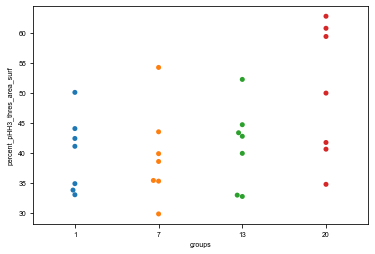

In [6]:
# Quick visualization of surface layer proliferation over time
sns.swarmplot(data=df, x='groups', y='percent_pHH3_thres_area_surf', order=['1', '7', '13', '20'])
tukeyTest(df.percent_pHH3_thres_area_surf, df.groups)

Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1     13   1.7304 0.8746  -4.7535  8.2142  False
     1     20   9.0585  0.004   2.5746 15.5424   True
     1      7   1.1172    0.9  -5.3666  7.6011  False
    13     20   7.3282 0.0226   0.8443  13.812   True
    13      7  -0.6131    0.9   -7.097  5.8708  False
    20      7  -7.9413 0.0124 -14.4252 -1.4574   True
-----------------------------------------------------
p values of all pair-wise tests:
 [0.87456838 0.0039618  0.9        0.02264018 0.9        0.01239473]


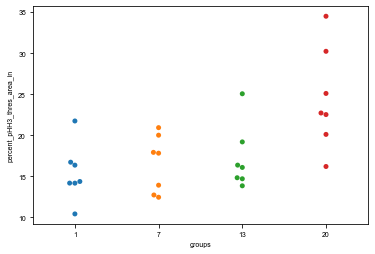

In [7]:
# Quick visualization of interior proliferation over time
sns.swarmplot(data=df, x='groups', y='percent_pHH3_thres_area_in', order=['1', '7', '13', '20'])
tukeyTest(df.percent_pHH3_thres_area_in, df.groups)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1     13  -0.0991    0.9 -0.8157 0.6175  False
     1     20  -0.5115 0.2274 -1.2281  0.205  False
     1      7  -0.1528    0.9 -0.8693 0.5638  False
    13     20  -0.4124 0.4053  -1.129 0.3041  False
    13      7  -0.0537    0.9 -0.7703 0.6629  False
    20      7   0.3587 0.5208 -0.3578 1.0753  False
---------------------------------------------------
p values of all pair-wise tests:
 [0.9        0.22738501 0.9        0.40528167 0.9        0.52079919]


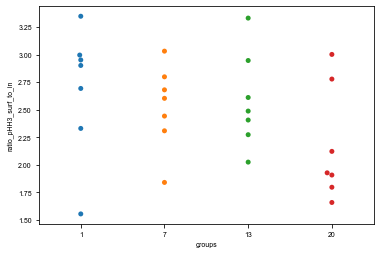

In [8]:
# Quick visualization of surface to interior proliferation ratios over time
sns.swarmplot(data=df, x='groups', y='ratio_pHH3_surf_to_in', order=['1', '7', '13', '20'])
tukeyTest(df.ratio_pHH3_surf_to_in, df.groups)

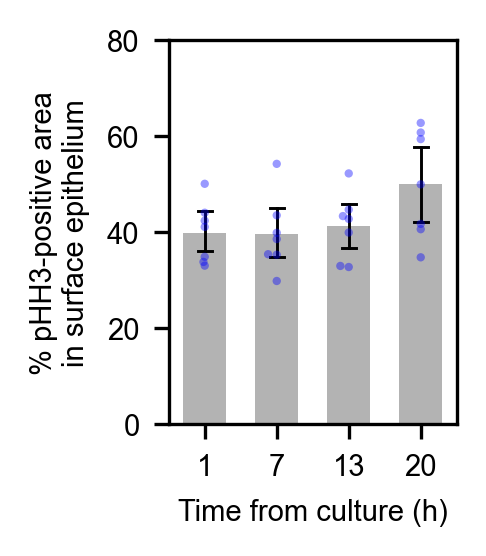

In [9]:
# Combined swarm and bar plot over time for figures

outputPrefix = '210206-SMG-time-course-proliferation-surface-epi-40x-bar-swarm'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
x_col = 'groups'
y_col = 'percent_pHH3_thres_area_surf'

fig_width=1.2
fig_height=1.6
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(data=df, x=x_col, y=y_col,
                   order=['1', '7', '13', '20'],
                   color="blue",
                   size=2.0,
                   alpha=.4)

ax = sns.barplot(data=df, x=x_col, y=y_col,
                 order=['1', '7', '13', '20'],
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)

plt.ylim(0, 80)
# plt.yticks([0, 10, 20])

plt.xlabel("Time from culture (h)")
plt.ylabel("% pHH3-positive area\nin surface epithelium")

# x_labels = ['1', '7', '13', '20']
# rotate x tick labels if necessary
# ax.set_xticklabels(labels=x_labels, rotation=60, ha="right")

# make the bar width narrower
change_bar_width(ax, .6)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


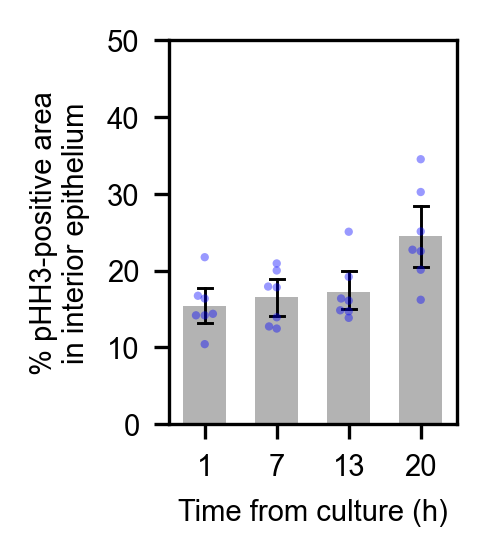

In [10]:
# Combined swarm and bar plot over time for figures

outputPrefix = '210206-SMG-time-course-proliferation-interior-epi-40x-bar-swarm'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
x_col = 'groups'
y_col = 'percent_pHH3_thres_area_in'

fig_width=1.2
fig_height=1.6
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(data=df, x=x_col, y=y_col,
                   order=['1', '7', '13', '20'],
                   color="blue",
                   size=2.0,
                   alpha=.4)

ax = sns.barplot(data=df, x=x_col, y=y_col,
                 order=['1', '7', '13', '20'],
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)

plt.ylim(0, 50)
# plt.yticks([0, 10, 20])

plt.xlabel("Time from culture (h)")
plt.ylabel("% pHH3-positive area\nin interior epithelium")

# x_labels = ['1', '7', '13', '20']
# rotate x tick labels if necessary
# ax.set_xticklabels(labels=x_labels, rotation=60, ha="right")

# make the bar width narrower
change_bar_width(ax, .6)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [11]:
df.columns

Index(['filename', 'area_in', 'area_surf', 'pHH3_mean_in', 'DAPI_mean_in',
       'Ecad_mean_in', 'pHH3_thres_area_in', 'DAPI_thres_area_in',
       'pHH3_mean_surf', 'DAPI_mean_surf', 'Ecad_mean_surf',
       'pHH3_thres_area_surf', 'DAPI_thres_area_surf', 'groups',
       'percent_pHH3_thres_area_surf', 'percent_pHH3_thres_area_in',
       'ratio_pHH3_surf_to_in'],
      dtype='object')

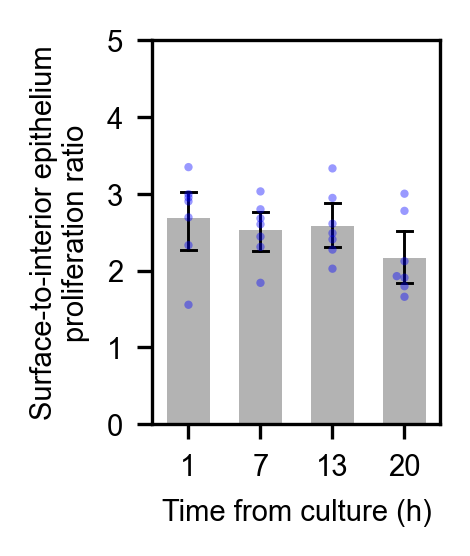

In [12]:
# Combined swarm and bar plot over time for figures

outputPrefix = '210206-SMG-time-course-proliferation-ratio-surf-to-interior-40x-bar-swarm'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
x_col = 'groups'
y_col = 'ratio_pHH3_surf_to_in'

fig_width=1.2
fig_height=1.6
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(data=df, x=x_col, y=y_col,
                   order=['1', '7', '13', '20'],
                   color="blue",
                   size=2.0,
                   alpha=.4)

ax = sns.barplot(data=df, x=x_col, y=y_col,
                 order=['1', '7', '13', '20'],
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)

plt.ylim(0, 5.0)
# plt.yticks([0, 10, 20])

plt.xlabel("Time from culture (h)")
plt.ylabel("Surface-to-interior epithelium\nproliferation ratio")

# x_labels = ['1', '7', '13', '20']
# rotate x tick labels if necessary
# ax.set_xticklabels(labels=x_labels, rotation=60, ha="right")

# make the bar width narrower
change_bar_width(ax, .6)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


### Make Smaller figure for supplemental figure

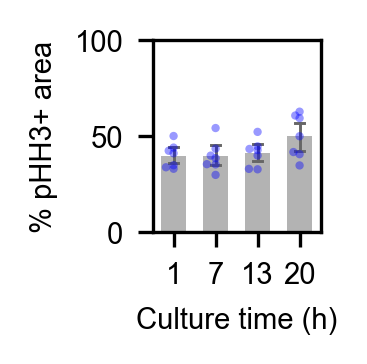

In [25]:
# surface

outputPrefix = '210206-SMG-time-course-proliferation-surface-epi-40x-bar-swarm-small'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
x_col = 'groups'
y_col = 'percent_pHH3_thres_area_surf'

fig_width = .7
fig_height = .8
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(data=df, x=x_col, y=y_col,
                   order=['1', '7', '13', '20'],
                   color="blue",
                   size=2.0,
                   alpha=.4)

ax = sns.barplot(data=df, x=x_col, y=y_col,
                 order=['1', '7', '13', '20'],
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor=".4", capsize=.2, ci=95)

plt.ylim(0, 100)
# plt.yticks([0, 10, 20])

plt.xlabel("Culture time (h)")
# plt.ylabel("% pHH3+ area\nin surface epithelium")
plt.ylabel("% pHH3+ area")
# plt.ylabel("%$\mathregular{pHH3^+}$ area")


# x_labels = ['1', '7', '13', '20']
# rotate x tick labels if necessary
# ax.set_xticklabels(labels=x_labels, rotation=60, ha="right")

# make the bar width narrower
change_bar_width(ax, .6)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


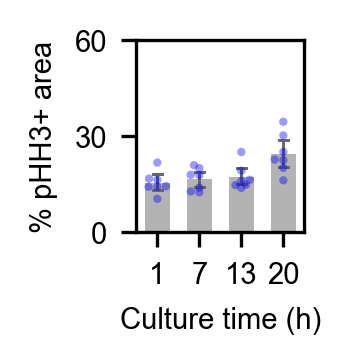

In [24]:
# interior

outputPrefix = '210206-SMG-time-course-proliferation-interior-epi-40x-bar-swarm-small'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
x_col = 'groups'
y_col = 'percent_pHH3_thres_area_in'

fig_width = .7
fig_height = .8
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(data=df, x=x_col, y=y_col,
                   order=['1', '7', '13', '20'],
                   color="blue",
                   size=2.0,
                   alpha=.4)

ax = sns.barplot(data=df, x=x_col, y=y_col,
                 order=['1', '7', '13', '20'],
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor=".4", capsize=.2, ci=95)

plt.ylim(0, 60)
plt.yticks([0, 30, 60])

plt.xlabel("Culture time (h)")
# plt.ylabel("% pHH3+ area\nin surface epithelium")
plt.ylabel("% pHH3+ area")
# plt.ylabel("%$\mathregular{pHH3^+}$ area")


# x_labels = ['1', '7', '13', '20']
# rotate x tick labels if necessary
# ax.set_xticklabels(labels=x_labels, rotation=60, ha="right")

# make the bar width narrower
change_bar_width(ax, .6)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


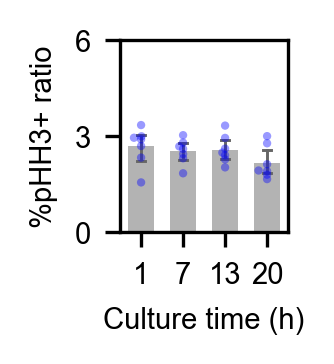

In [31]:
# surface-to-interior ratio

outputPrefix = '210206-SMG-time-course-proliferation-ratio-surf-to-interior-40x-bar-swarm-small'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
x_col = 'groups'
y_col = 'ratio_pHH3_surf_to_in'

fig_width = .7
fig_height = .8
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(data=df, x=x_col, y=y_col,
                   order=['1', '7', '13', '20'],
                   color="blue",
                   size=2.0,
                   alpha=.4)

ax = sns.barplot(data=df, x=x_col, y=y_col,
                 order=['1', '7', '13', '20'],
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor=".4", capsize=.2, ci=95)

plt.ylim(0, 6)
plt.yticks([0, 3, 6])

plt.xlabel("Culture time (h)")
# plt.ylabel("Surface-to-interior epithelium\nproliferation ratio")
plt.ylabel("%pHH3+ ratio")

# x_labels = ['1', '7', '13', '20']
# rotate x tick labels if necessary
# ax.set_xticklabels(labels=x_labels, rotation=60, ha="right")

# make the bar width narrower
change_bar_width(ax, .6)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)
